<a href="https://colab.research.google.com/github/sandarnaing/tutorial/blob/main/tutorial_2_dataprofessor/Cheminformatics_predicting_solubility_100124.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install rdkit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 27.1 MB/s eta 0:00:00


In [2]:
! wget https://raw.githubusercontent.com/dataprofessor/data/master/delaney.csv

--2024-01-10 16:36:53--  https://raw.githubusercontent.com/dataprofessor/data/master/delaney.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 58889 (58K) [text/plain]
Saving to: ‘delaney.csv’

delaney.csv         100%[===================>]  57.51K  --.-KB/s    in 0.01s   

2024-01-10 16:36:54 (3.91 MB/s) - ‘delaney.csv’ saved [58889/58889]



In [3]:
import pandas as pd

sol = pd.read_csv('delaney.csv')
sol

,Compound ID,measured log(solubility:mol/L),ESOL predicted log(solubility:mol/L),SMILES
0,"1,1,1,2-Tetrachloroethane",-2.180,-2.794,ClCC(Cl)(Cl)Cl
1,"1,1,1-Trichloroethane",-2.000,-2.232,CC(Cl)(Cl)Cl
2,"1,1,2,2-Tetrachloroethane",-1.740,-2.549,ClC(Cl)C(Cl)Cl
3,"1,1,2-Trichloroethane",-1.480,-1.961,ClCC(Cl)Cl
4,"1,1,2-Trichlorotrifluoroethane",-3.040,-3.077,FC(F)(Cl)C(F)(Cl)Cl
...,...,...,...,...
1139,vamidothion,1.144,-1.446,CNC(=O)C(C)SCCSP(=O)(OC)(OC)
1140,Vinclozolin,-4.925,-4.377,CC1(OC(=O)N(C1=O)c2cc(Cl)cc(Cl)c2)C=C
1141,Warfarin,-3.893,-3.913,CC(=O)CC(c1ccccc1)c3c(O)c2ccccc2oc3=O
1142,Xipamide,-3.790,-3.642,Cc1cccc(C)c1NC(=O)c2cc(c(Cl)cc2O)S(N)(=O)=O


In [4]:
sol.SMILES

0                                    ClCC(Cl)(Cl)Cl
1                                      CC(Cl)(Cl)Cl
2                                    ClC(Cl)C(Cl)Cl
3                                        ClCC(Cl)Cl
4                               FC(F)(Cl)C(F)(Cl)Cl
                           ...                     
1139                   CNC(=O)C(C)SCCSP(=O)(OC)(OC)
1140          CC1(OC(=O)N(C1=O)c2cc(Cl)cc(Cl)c2)C=C
1141         CC(=O)CC(c1ccccc1)c3c(O)c2ccccc2oc3=O 
1142    Cc1cccc(C)c1NC(=O)c2cc(c(Cl)cc2O)S(N)(=O)=O
1143                         CNC(=O)Oc1cc(C)cc(C)c1
Name: SMILES, Length: 1144, dtype: object

In [6]:
from rdkit import Chem
mol_list = []
for element in sol.SMILES:
  mol = Chem.MolFromSmiles(element)
  mol_list.append(mol)

In [7]:
len(mol_list)

1144

In [8]:
import numpy as np
from rdkit.Chem import Descriptors

def generate(smiles, verbose = False):
  moldata = []
  for elem in smiles:
    mol = Chem.MolFromSmiles(elem)
    moldata.append(mol)

  baseData = np.arange(1,1)
  i = 0
  for mol in moldata:
    desc_MolLogP = Descriptors.MolLogP(mol)
    desc_MolWt = Descriptors.MolWt(mol)
    desc_NumRotatableBonds = Descriptors.NumRotatableBonds(mol)
    row = np.array([desc_MolLogP,
                    desc_MolWt,
                    desc_NumRotatableBonds])
    if(i == 0):
      baseData = row
    else:
      baseData = np.vstack([baseData, row])
    i = i+1

  columnNames = ["MolLogP", "MolWt", "NumRotatableBonds"]
  descriptors = pd.DataFrame(data = baseData, columns = columnNames)

  return descriptors

In [9]:
df = generate(sol.SMILES)
df

,MolLogP,MolWt,NumRotatableBonds
0,2.59540,167.850,0.0
1,2.37650,133.405,0.0
2,2.59380,167.850,1.0
3,2.02890,133.405,1.0
4,2.91890,187.375,1.0
...,...,...,...
1139,1.98820,287.343,8.0
1140,3.42130,286.114,2.0
1141,3.60960,308.333,4.0
1142,2.56214,354.815,3.0


In [10]:
m = Chem.MolFromSmiles('COc1cccc2cc(C(=O)NCCCCN3CCN(c4cccc5nccnc54)CC3)oc21')
aromatic_atoms = [m.GetAtomWithIdx(i).GetIsAromatic() for i in range(m.GetNumAtoms())]
aromatic_atoms

[False,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 False,
 True,
 True]

In [11]:
def AromaticAtoms(m):
  aromatic_atoms = [m.GetAtomWithIdx(i).GetIsAromatic() for i in range(m.GetNumAtoms())]
  aa_count = []
  for i in aromatic_atoms:
    if i == True:
      aa_count.append(1)
  sum_aa_count = sum(aa_count)
  return sum_aa_count

In [12]:
AromaticAtoms(m)

19

In [13]:
desc_AromaticAtoms = [AromaticAtoms(element) for element in mol_list]
desc_AromaticAtoms

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 0,
 6,
 0,
 0,
 0,
 0,
 6,
 6,
 0,
 6,
 6,
 6,
 6,
 6,
 0,
 6,
 6,
 0,
 0,
 6,
 10,
 6,
 6,
 0,
 6,
 6,
 6,
 6,
 10,
 6,
 0,
 10,
 0,
 14,
 0,
 0,
 14,
 0,
 0,
 0,
 0,
 10,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 10,
 0,
 0,
 0,
 0,
 0,
 10,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 10,
 0,
 0,
 12,
 10,
 14,
 6,
 10,
 10,
 10,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 6,
 0,
 0,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 0,
 12,
 12,
 12,
 12,
 0,
 0,
 12,
 0,
 0,
 0,
 0,
 0,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 6,
 6,
 12,
 12,
 6,
 0,
 6,
 12,
 6,
 6,
 6,
 6,
 0,
 0,
 10,
 0,
 6,
 12,
 12,
 6,
 12,
 6,
 6,
 6,
 6,
 0,
 0,
 0,
 0,
 6,
 6,
 6,
 12,
 12,
 6,
 10,
 6,
 6,
 6,
 12,
 10,
 14,
 10,
 10,
 0,
 6,
 0,
 0,
 0,
 0,
 6,
 12,
 0,
 10,
 6,
 0,
 6,
 0,
 0,
 6,
 0,
 0,
 0,
 0,
 0,
 10,
 6,
 0,
 0,
 0,
 0,
 10,
 6,
 0,
 6,
 10,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 14,
 0,

In [14]:
df_desc_AromaticProportion = pd.DataFrame(desc_AromaticAtoms, columns = ['AromaticProportion'])
df_desc_AromaticProportion

,AromaticProportion
0,0
1,0
2,0
3,0
4,0
...,...
1139,0
1140,6
1141,16
1142,12


In [15]:
X = pd.concat([df,df_desc_AromaticProportion], axis = 1)
X

,MolLogP,MolWt,NumRotatableBonds,AromaticProportion
0,2.59540,167.850,0.0,0
1,2.37650,133.405,0.0,0
2,2.59380,167.850,1.0,0
3,2.02890,133.405,1.0,0
4,2.91890,187.375,1.0,0
...,...,...,...,...
1139,1.98820,287.343,8.0,0
1140,3.42130,286.114,2.0,6
1141,3.60960,308.333,4.0,16
1142,2.56214,354.815,3.0,12


In [16]:
X.to_csv('delaney_solubility_descriptor.csv')

In [17]:
Y = sol.iloc[:,1]
Y

0      -2.180
1      -2.000
2      -1.740
3      -1.480
4      -3.040
        ...  
1139    1.144
1140   -4.925
1141   -3.893
1142   -3.790
1143   -2.581
Name: measured log(solubility:mol/L), Length: 1144, dtype: float64

In [19]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [21]:
model = DecisionTreeRegressor(random_state = 42)
model.fit(X, Y)
r2 = model.score(X, Y)
r2

0.9946997644627119

In [23]:
Y_pred = model.predict(X)

In [24]:
print('Mean squared error (MSE): %.2f'
        % mean_squared_error(Y, Y_pred))
print('Coefficient of determination (R^2): %.2f'
        % r2_score(Y, Y_pred))

Mean squared error (MSE): 0.02
Coefficient of determination (R^2): 0.99


In [25]:
import matplotlib.pyplot as plt

<function matplotlib.pyplot.show(close=None, block=None)>

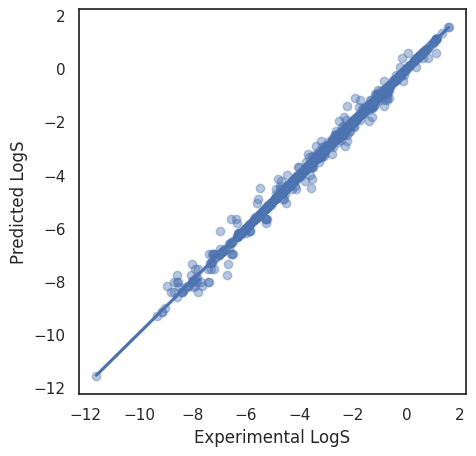

In [26]:
import seaborn as sns
sns.set(color_codes = True)
sns.set_style("white")
ax = sns.regplot(x = Y, y = Y_pred, scatter_kws = {'alpha':0.4})
ax.set_xlabel('Experimental LogS')
ax.set_ylabel('Predicted LogS')
ax.figure.set_size_inches(5,5)
plt.show